In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style as style
style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### GOAL: Given a match score, what is the probability of team 1 winning?

In [87]:
rounds_df = pd.read_csv('../data/rounds.csv')
winners_df = pd.read_csv('../data/winners.csv')

# Join on map_id and map
data = pd.merge(rounds_df, winners_df, on=['map_id', 'map'])
print('Number of maps:', len(data['map_id'].unique()))

Number of maps: 51639


- Collect all possible score lines
- Check outcomes
- Get probability
- Need to consider the complement of a score line (7 - 8 and 8 - 7)

In [92]:
%%time

'''LIST OF DICTIONARIES VARIATION FOR DATAFRAME FORMATION'''

# All possible score lines
all_team1_scores = data['team1_score'].unique()
all_team2_scores = data['team2_score'].unique()

# Collect win counts
scorelines = []
for score1 in all_team1_scores:
    for score2 in all_team2_scores:
#         print('Score Line:', score1, '-', score2)
        
        # Get data points with particular score line
        condition = (data['team1_score'] == score1) & (data['team2_score'] == score2)
        subset = data.loc[condition,]
        total_maps = subset.shape[0]
#         print('# Maps:', total_maps)
        
        # Check when team 1 wins
        condition = (subset['team1_id'] == subset['winner_id'])
        team1_winning = subset.loc[condition,]
        total_team1_wins = team1_winning.shape[0]
#         print('# Team 1 wins:', total_team1_wins)
#         print('# Team 2 wins:', total_maps - total_team1_wins)
        
        # Add win counts to dictionary
        scoreline = {}
        scoreline['team1_score'] = score1
        scoreline['team2_score'] = score2
        scoreline['team1_wins'] = total_team1_wins
        scoreline['team2_wins'] = total_maps - total_team1_wins
        scorelines.append(scoreline)
        
scoreline_df = pd.DataFrame(scorelines)

CPU times: user 2.14 s, sys: 51.1 ms, total: 2.19 s
Wall time: 2.21 s


In [169]:
%%time

'''LIST VARIATION FOR DATAFRAME FORMATION'''

# All possible score lines
all_team1_scores = data['team1_score'].unique()
all_team2_scores = data['team2_score'].unique()

# Collect win counts
scores1 = []
scores2 = []
all_team1_wins = []
all_team2_wins = []
for score1 in all_team1_scores:
    for score2 in all_team2_scores:
#         print('Score Line:', score1, '-', score2)
        
        # Get data points with particular score line
        condition = (data['team1_score'] == score1) & (data['team2_score'] == score2)
        subset = data.loc[condition,]
        total_maps = subset.shape[0]
#         print('# Maps:', total_maps)
        
        # Check when team 1 wins
        condition = (subset['team1_id'] == subset['winner_id'])
        team1_winning = subset.loc[condition,]
        total_team1_wins = team1_winning.shape[0]
#         print('# Team 1 wins:', total_team1_wins)
#         print('# Team 2 wins:', total_maps - total_team1_wins)
        
        # Add win counts to lists
        scores1.append(score1)
        scores2.append(score2)
        all_team1_wins.append(total_team1_wins)
        all_team2_wins.append(total_maps - total_team1_wins)
        
scoreline_df = pd.DataFrame({
    'team1_score': scores1,
    'team2_score': scores2,
    'team1_wins': all_team1_wins,
    'team2_wins': all_team2_wins
})



CPU times: user 2.11 s, sys: 51.4 ms, total: 2.17 s
Wall time: 2.18 s


In [170]:
scoreline_df.head(16)

,team1_score,team2_score,team1_wins,team2_wins
0,0,1,11021,14202
1,0,2,7824,12353
2,0,3,5656,10349
3,0,4,2573,6504
4,0,5,1521,5055
5,0,6,657,3213
6,0,7,333,2297
7,0,8,176,1527
8,0,9,95,1046
9,0,10,49,702


You can see some edge cases where (i.e. 0 - 16) where team1 is the winner. This is an issue with HLTV incorrectly labeling their data. 

We now need to get the complement of each score line and give the probabilities.

In [173]:
%%time
scores1 = []
scores2 = []
score1_wins = []
score2_wins = []

# Combine score lines that are complements
for score1 in all_team1_scores:
    for score2 in all_team2_scores:
        
        if score1 == score2:
            scores1.append(score1)
            scores2.append(score2)
            condition = (scoreline_df['team1_score'] == score1) & (scoreline_df['team2_score'] == score2)
            score1_wins.append(scoreline_df.loc[condition, 'team1_wins'].values[0])
            score2_wins.append(scoreline_df.loc[condition, 'team2_wins'].values[0])
            # Need to average out to 0.5
            
        else:
            scores1.append(score1)
            scores2.append(score2)
            condition1 = (scoreline_df['team1_score'] == score1) & (scoreline_df['team2_score'] == score2)
            condition2 = (scoreline_df['team1_score'] == score2) & (scoreline_df['team2_score'] == score1)
            subset1 = scoreline_df.loc[condition1,]
            subset2 = scoreline_df.loc[condition2,]
            score1_wins.append(subset1.loc[condition1, 'team1_wins'].values[0] + subset2.loc[condition2, 'team2_wins'].values[0])
            score2_wins.append(subset1.loc[condition1, 'team2_wins'].values[0] + subset2.loc[condition2, 'team1_wins'].values[0])
        
scoreline_df2 = pd.DataFrame({
    'Score 1': scores1,
    'Score 2': scores2,
    'Score 1 Wins': score1_wins,
    'Score 2 Wins': score2_wins
})

# # Keep only cases where the higher score is present; essentially drop rows containing the same info
# scoreline_df2 = scoreline_df2.loc[scoreline_df2['Higher Score'] >= scoreline_df2['Lower Score'],]

# Calculate Higher Score and Lower Score Win Probabilities
scoreline_df2.loc[:,'Score 1 Win Prob'] = scoreline_df2.loc[:,'Score 1 Wins'] / \
    (scoreline_df2.loc[:,'Score 1 Wins'] + scoreline_df2.loc[:,'Score 2 Wins'])

scoreline_df2.loc[:,'Score 2 Win Prob'] = 1 - scoreline_df2.loc[:,'Score 1 Win Prob']

# Since there is no complement for even scores they will be set to 0.5 probability
scoreline_df2.loc[scoreline_df2['Score 1'] == scoreline_df2['Score 2'], 'Score 1 Win Prob'] = 0.5
scoreline_df2.loc[scoreline_df2['Score 1'] == scoreline_df2['Score 2'], 'Score 2 Win Prob'] = 0.5

# Drop rows with NA
scoreline_df2.dropna(inplace=True)

CPU times: user 1.17 s, sys: 19.6 ms, total: 1.19 s
Wall time: 1.18 s


### Plotting time

Text(0, 0.5, 'Win probability')

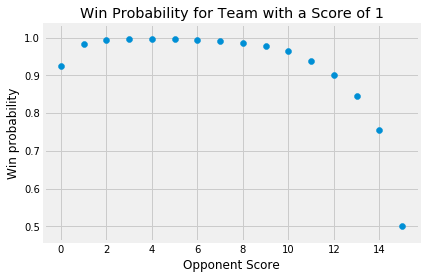

In [187]:
# Individual Score Line
score = 1
condition = scoreline_df2['Score 1'] == 15
tmp_df = scoreline_df2[condition]
x_feature = 'Score 2'
y_feature = 'Score 1 Win Prob'
plt.scatter(tmp_df[x_feature], tmp_df[y_feature])
plt.title('Win Probability for Team with a Score of ' + str(score))
plt.xlabel('Opponent Score')
plt.ylabel('Win probability')
plt.show()

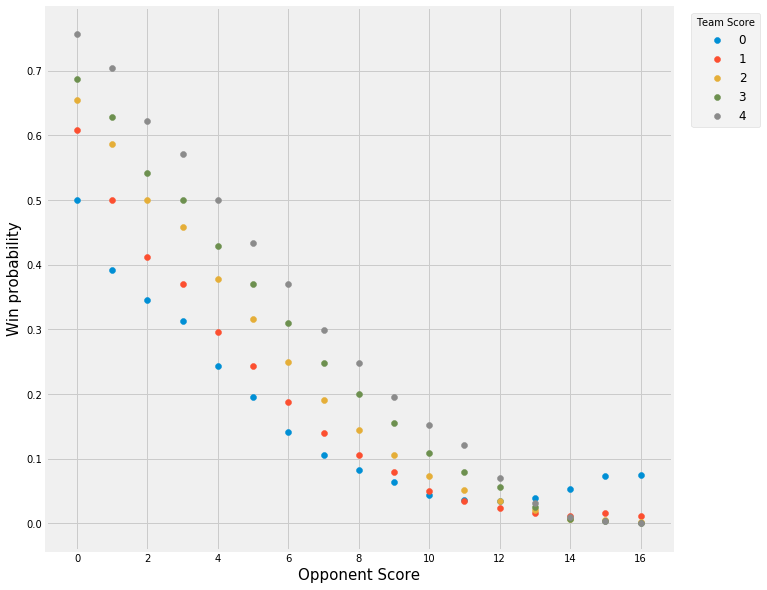

In [225]:
# All Score Lines
plt.figure(figsize=(10,10))
for i in range(5):
    score = i
    condition = scoreline_df2['Score 1'] == score
    tmp_df = scoreline_df2[condition]
    x_feature = 'Score 2'
    y_feature = 'Score 1 Win Prob'
    plt.scatter(tmp_df[x_feature], tmp_df[y_feature], label=str(score))
#     plt.title('Win Probability for Team with a Score of ' + str(score))
    plt.xlabel('Opponent Score', fontsize=15)
    plt.ylabel('Win probability', fontsize=15)
    score += 1
plt.legend(title="Team Score", fontsize=12, bbox_to_anchor=(1.15, 1.0))
plt.show()

#### OLD CODE:

In [71]:
score1 = 7
score2 = 8
print('Score Line:', score1, '-', score2)
condition1 = (data['team1_score'] == score1) & (data['team2_score'] == score2)
subset1 = data.loc[condition1,]
print('# Maps:', subset1.shape[0])

# Check when team 1 is winner
condition1 = (subset1['team1_id'] == subset1['winner_id'])
stuff = subset1.loc[condition1,]
print('# Team 1 wins:', stuff.shape[0])

win_prob = stuff.shape[0] / subset1.shape[0]
print('Percent of time team 1 wins', win_prob)
subset1.head()

Score Line: 7 - 8
# Maps: 1075
# Team 1 wins: 514
Percent of time team 1 wins 0.4781395348837209


,ctTeam,map,map_id,outcome,tTeam,team1_score,team2_score,team1_id,team2_id,date,winner_id,winner_name
14,7489,mrg,40405,t_win,4610,7,8,4610,7489,1483023600000,4610,RuSh3D
709,7524,cch,40372,ct_win,7145,7,8,7145,7524,1482750600000,7524,BOOYAKA
929,7528,mrg,40361,ct_win,7526,7,8,7526,7528,1482660000000,7528,HegemonyPerson
1172,7528,trn,40352,ct_win,7094,7,8,7528,7094,1482584400000,7528,HegemonyPerson
1421,7182,cch,40332,ct_win,7145,7,8,7145,7182,1482501600000,7182,zARLANS


In [72]:
print('Score Line:', score2, '-', score1)
condition2 = (data['team1_score'] == score2) & (data['team2_score'] == score1)
subset2 = data.loc[condition2,]
print('# Maps:', subset2.shape[0])

# Check when team 1 is winner
condition2 = (subset2['team1_id'] == subset2['winner_id'])
stuff = subset2.loc[condition2,]
print('# Team 1 wins:', stuff.shape[0])

win_prob = stuff.shape[0] / subset2.shape[0]
print('Percent of time team 1 wins', win_prob)
subset1.head()

Score Line: 8 - 7
# Maps: 1137
# Team 1 wins: 663
Percent of time team 1 wins 0.58311345646438


,ctTeam,map,map_id,outcome,tTeam,team1_score,team2_score,team1_id,team2_id,date,winner_id,winner_name
14,7489,mrg,40405,t_win,4610,7,8,4610,7489,1483023600000,4610,RuSh3D
709,7524,cch,40372,ct_win,7145,7,8,7145,7524,1482750600000,7524,BOOYAKA
929,7528,mrg,40361,ct_win,7526,7,8,7526,7528,1482660000000,7528,HegemonyPerson
1172,7528,trn,40352,ct_win,7094,7,8,7528,7094,1482584400000,7528,HegemonyPerson
1421,7182,cch,40332,ct_win,7145,7,8,7145,7182,1482501600000,7182,zARLANS
